In [1]:
!pip3 install imbalanced-learn -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.subplots as sp
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
import json
from imblearn.over_sampling import ADASYN
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
# Load data
df = pd.read_csv('../data/credit_scoring.csv')

# Drop kolom leakage
leak_cols = ['leak_col_good', 'leak_col_subtle']
df_clean = df.drop(columns=leak_cols)

# Drop application_id (tidak informatif untuk prediksi)
df_clean = df_clean.drop(columns=['application_id'])

df_clean

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


In [4]:
# Melihat tipe data dan null data

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                6000 non-null   int64
 1   monthly_income     6000 non-null   int64
 2   loan_amount        6000 non-null   int64
 3   previous_defaults  6000 non-null   int64
 4   credit_score       6000 non-null   int64
 5   default            6000 non-null   int64
dtypes: int64(6)
memory usage: 281.4 KB


In [5]:
df_clean.describe()

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
count,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167
std,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639
min,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000
25%,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000
50%,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000
75%,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000
max,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000


## SPLITING DATA

In [6]:
# Tahap 1: Split 80% ke train, 20% ke sisa (val+test)
df_train, df_temp = train_test_split(
    df_clean, test_size=0.2, stratify=df_clean['default'], random_state=42
)

# Tahap 2: Split sisa (20%) menjadi 10% validasi, 10% test
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp['default'], random_state=42
)

# Hasil akhir:
print(f"Train set    : {df_train.shape[0]} rows")
print(f"Validation   : {df_val.shape[0]} rows")
print(f"Test set     : {df_test.shape[0]} rows\n")

# Cek distribusi target di tiap subset
print(f"Proporsi default (Train):      {df_train['default'].mean():.4f}")
print(f"Proporsi default (Validation): {df_val['default'].mean():.4f}")
print(f"Proporsi default (Test):       {df_test['default'].mean():.4f}")

Train set    : 4800 rows
Validation   : 600 rows
Test set     : 600 rows

Proporsi default (Train):      0.0121
Proporsi default (Validation): 0.0133
Proporsi default (Test):       0.0117


## EDA

In [7]:
# Pilih kolom numerik utama
columns = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

# Hitung jumlah nilai unik
unique_counts = [df_train[col].nunique() for col in columns]

# Buat tabel interaktif
fig = go.Figure(data=[go.Table(
    header=dict(values=['Kolom', 'Jumlah Nilai Unik']),
    cells=dict(values=[columns, unique_counts])
)])

fig.update_layout(title='Jumlah Nilai Unik per Kolom')
fig.show()

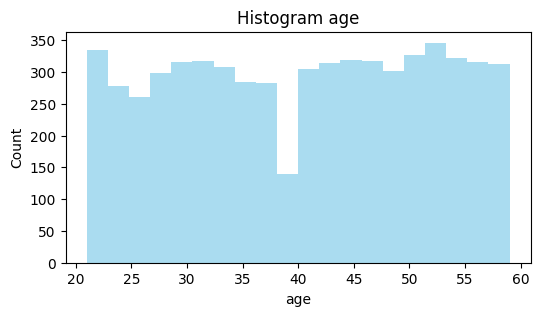

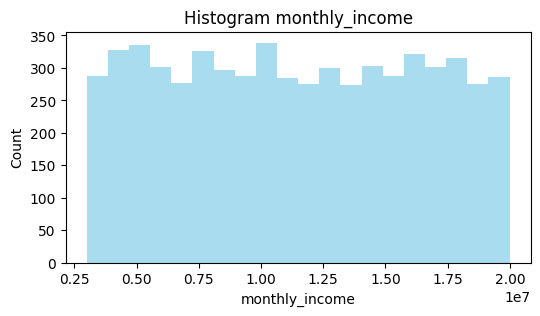

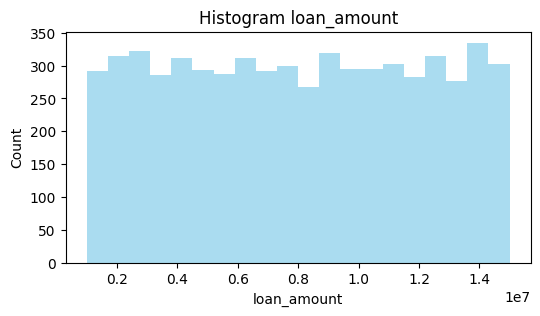

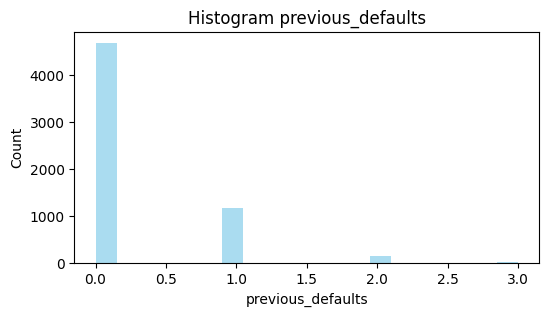

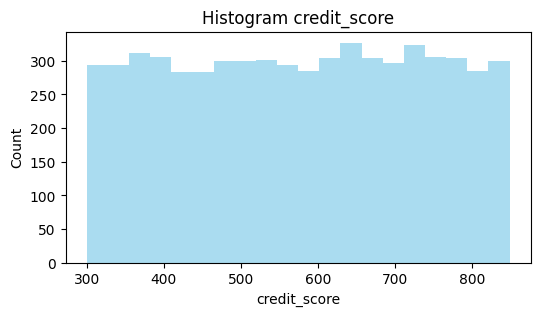

In [8]:
num_cols = df_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('default')  # tidak usah target

for col in num_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(df_clean[col], bins=20, alpha=0.7, color='skyblue')
    plt.title(f'Histogram {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [9]:
for feature in ['age', 'monthly_income', 'loan_amount', 'credit_score']:
    stat, p = shapiro(df_train[feature].sample(500, random_state=42))  # Max 500 sample (Shapiro limit)
    print(f'{feature} | p-value: {p:.5f} | {"Normal" if p>0.05 else "Tidak normal"}')

age | p-value: 0.00000 | Tidak normal
monthly_income | p-value: 0.00000 | Tidak normal
loan_amount | p-value: 0.00000 | Tidak normal
credit_score | p-value: 0.00000 | Tidak normal


In [10]:
# Lihat skala apakah sudah tepat 300-850

min_score = df_train['credit_score'].min()
max_score = df_train['credit_score'].max()

print(f'Nilai terendah credit_score: {min_score}')
print(f'Nilai tertinggi credit_score: {max_score}')

Nilai terendah credit_score: 300
Nilai tertinggi credit_score: 849


In [11]:
# Data untuk plot
default_counts = df_train['default'].value_counts()
default_pct = df_train['default'].value_counts(normalize=True) * 100

fig = px.bar(
    x=default_counts.index.astype(str),
    y=default_counts.values,
    text=[f'{p:.2f}%' for p in default_pct],
    labels={'x': 'Default', 'y': 'Jumlah'},
    title='Distribusi Target: Default vs Non-default'
)

# Supaya label tidak terpotong:
fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis=dict(tickformat=',d', range=[0, default_counts.max() * 1.2]),  # yaxis dinaikkan
    margin=dict(t=80, b=40, l=60, r=60)  # Tambah margin atas/bawah/kiri/kanan
)

fig.show()

#### ASUMSI

##### - Default adalah target label:
###### 1 = gagal bayar (default)
###### 0 = tidak gagal bayar (tidak default)

##### - previous_defaults adalah jumlah kegagalan bayar di masa lalu (di pinjaman sebelumnya, bisa 0, 1, 2, atau 3 kali).

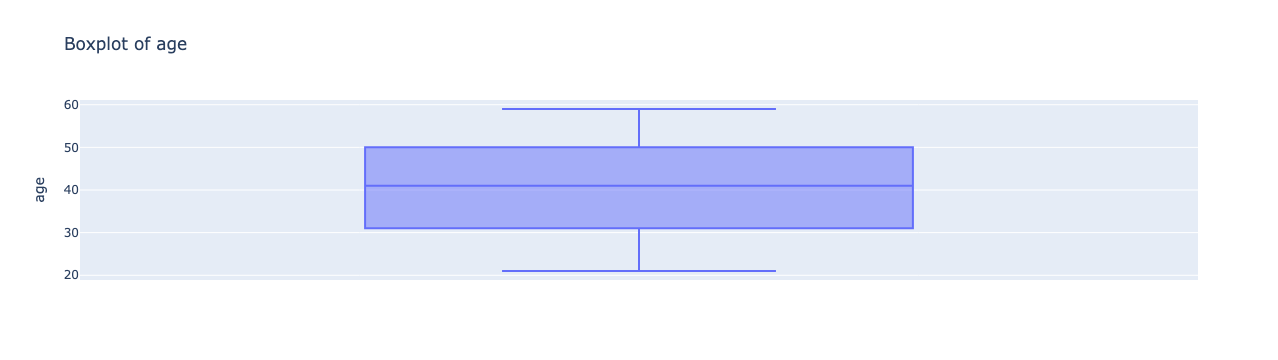

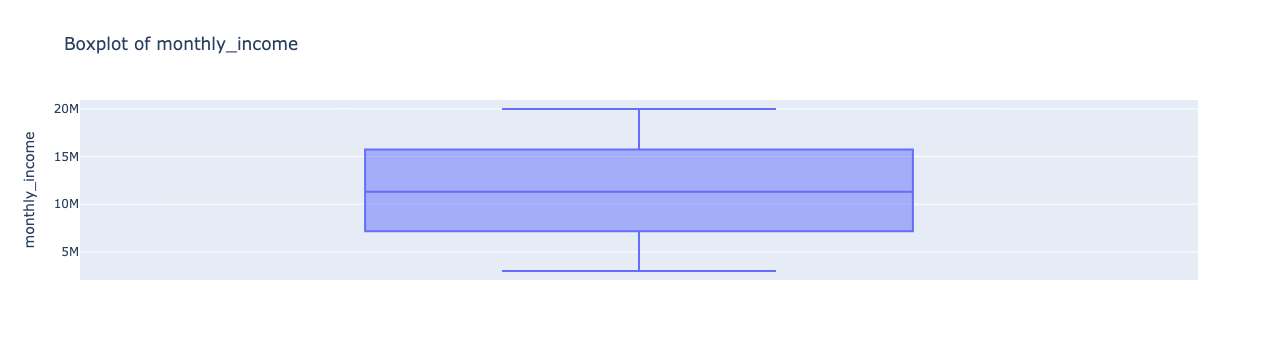

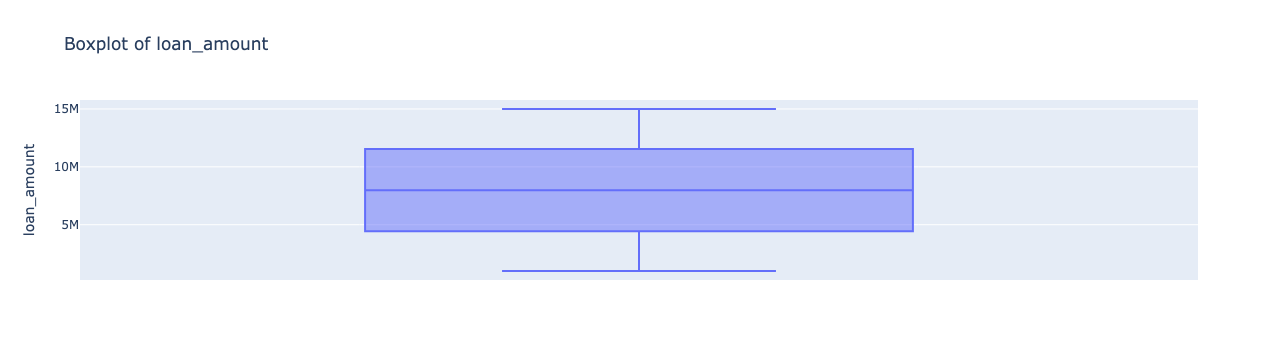

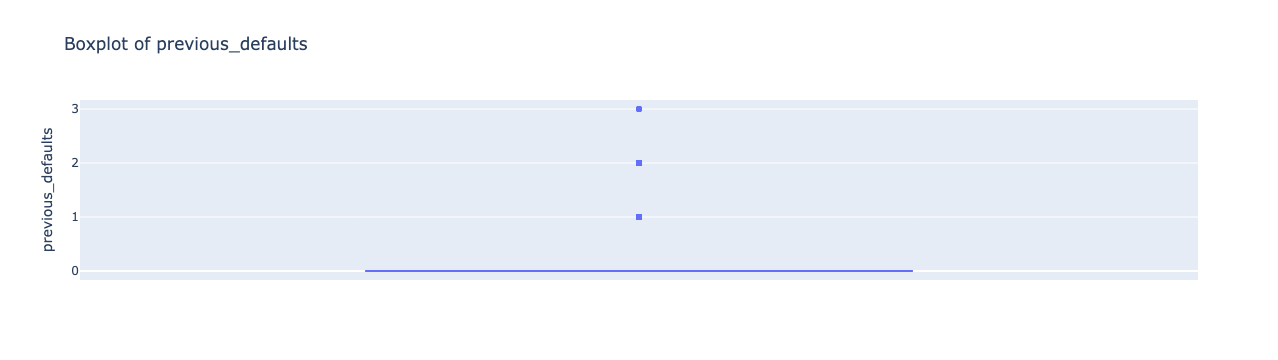

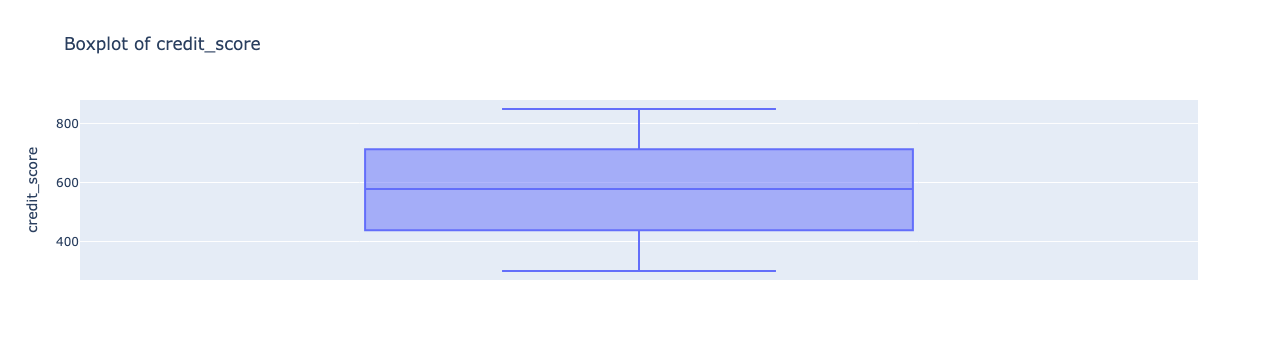

In [12]:
# Loop boxplot untuk setiap fitur numerik (kecuali target)
num_cols = df_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('default')

for col in num_cols:
    fig = px.box(df_clean, y=col, title=f'Boxplot of {col}')
    fig.show()

In [13]:
# Presentase outlier

for col in num_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_out = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f'{col}: {n_out} outlier ({n_out/len(df_clean)*100:.2f}%)')

age: 0 outlier (0.00%)
monthly_income: 0 outlier (0.00%)
loan_amount: 0 outlier (0.00%)
previous_defaults: 1314 outlier (21.90%)
credit_score: 0 outlier (0.00%)


In [14]:
df_train.corr()

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
age,1.000000,-0.013844,0.009990,-0.006814,0.007558,0.001169
monthly_income,-0.013844,1.000000,-0.007674,0.013885,0.013466,-0.062206
loan_amount,0.009990,-0.007674,1.000000,0.007415,0.025951,0.074503
previous_defaults,-0.006814,0.013885,0.007415,1.000000,0.005384,0.053876
credit_score,0.007558,0.013466,0.025951,0.005384,1.000000,-0.064042
default,0.001169,-0.062206,0.074503,0.053876,-0.064042,1.000000


## Data Preprocessing

In [15]:
# # Ubah range/binning data train

# # Age
# age_bins = pd.qcut(df_train['age'], q=4, retbins=True)[1]  # Dapatkan interval/range
# df_train['age'] = pd.cut(df_train['age'], bins=age_bins, labels=[1, 2, 3, 4], include_lowest=True)

# # Monthly Income
# income_bins = pd.qcut(df_train['monthly_income'], q=4, retbins=True)[1]
# df_train['monthly_income'] = pd.cut(df_train['monthly_income'], bins=income_bins, labels=[1, 2, 3, 4], include_lowest=True)

# # Loan Amount
# loan_bins = pd.qcut(df_train['loan_amount'], q=4, retbins=True)[1]
# df_train['loan_amount'] = pd.cut(df_train['loan_amount'], bins=loan_bins, labels=[1, 2, 3, 4], include_lowest=True)

# # Credit Score
# credit_bins = pd.qcut(df_train['credit_score'], q=4, retbins=True)[1]
# df_train['credit_score'] = pd.cut(df_train['credit_score'], bins=loan_bins, labels=[1, 2, 3, 4], include_lowest=True)

# # Simpan intervalnya jika mau pakai di data lain
# print("Age bins:", age_bins)
# print("Monthly Income bins:", income_bins)
# print("Loan Amount bins:", loan_bins)
# print("Credit Score bins:", credit_bins)

# # Simpan interval/bin ke file JSON
# bin_ranges = {
#     'age': list(age_bins),
#     'monthly_income': list(income_bins),
#     'loan_amount': list(loan_bins),
#     'credit_score': list(credit_bins)
# }

# with open('../data/bin_ranges.json', 'w') as f:
#     json.dump(bin_ranges, f)

In [16]:
# # Ubah range/binning data validation

# # Load dari file JSON
# with open('../data/bin_ranges.json', 'r') as f:
#     bin_ranges = json.load(f)

# # Extend age bins
# age_bins = bin_ranges['age']
# age_bins[-1] = np.inf  # Ubah batas atas jadi tak hingga

# # Extend income bins
# income_bins = bin_ranges['monthly_income']
# income_bins[-1] = np.inf

# # Extend loan bins
# loan_bins = bin_ranges['loan_amount']
# loan_bins[-1] = np.inf

# # Extend credit bins
# credit_bins = bin_ranges['credit_score']
# credit_bins[-1] = np.inf

# # Contoh pakai ke data test
# df_val['age'] = pd.cut(
#     df_val['age'],
#     bins=age_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_val['monthly_income'] = pd.cut(
#     df_val['monthly_income'],
#     bins=income_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_val['loan_amount'] = pd.cut(
#     df_val['loan_amount'],
#     bins=loan_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_val['credit_score'] = pd.cut(
#     df_val['credit_score'],
#     bins=credit_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )

In [17]:
# Tentukan kolom numerik yang akan discaling (tanpa kolom target)
num_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

# Fit scaler di data training
scaler = StandardScaler()
scaler.fit(df_train[num_cols])

# Transformasi semua set (pakai scaler dari train!)
df_train[num_cols] = scaler.transform(df_train[num_cols])
df_val[num_cols] = scaler.transform(df_val[num_cols])

In [18]:
# Inbalance Handling menggunakan ADASYN

# Misal df_train sudah diproses dan punya kolom target 'default'
X_train = df_train.drop(columns=['default'])
y_train = df_train['default']

# Oversampling dengan ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Sebelum oversampling:')
print(y_train.value_counts())
print('\nSetelah ADASYN oversampling:')
print(y_res.value_counts())

Sebelum oversampling:
default
0    4742
1      58
Name: count, dtype: int64

Setelah ADASYN oversampling:
default
0    4742
1    4723
Name: count, dtype: int64


## TRAIN AND VALIDATION

### Logistic Regression

In [19]:
X_val = df_val.drop(columns=['default'])
y_val = df_val['default']

# Fit pada train hasil oversampling
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_res, y_res)  # X_res, y_res = hasil ADASYN

# Prediksi pada validation set
y_val_pred = base_model.predict(X_val)
y_val_prob = base_model.predict_proba(X_val)[:, 1]

# Evaluasi
# Train
y_train_pred = base_model.predict(X_res)
y_train_prob = base_model.predict_proba(X_res)[:,1]
print("=== TRAIN SET ===")
print(classification_report(y_res, y_train_pred))
print("AUC Train:", roc_auc_score(y_res, y_train_prob))

# Validation
y_val_pred = base_model.predict(X_val)
y_val_prob = base_model.predict_proba(X_val)[:,1]
print("\n=== VALIDATION SET ===")
print(classification_report(y_val, y_val_pred))
print("AUC Validation:", roc_auc_score(y_val, y_val_prob))

=== TRAIN SET ===
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      4742
           1       0.75      0.83      0.79      4723

    accuracy                           0.78      9465
   macro avg       0.78      0.78      0.78      9465
weighted avg       0.78      0.78      0.78      9465

AUC Train: 0.8291376416261387

=== VALIDATION SET ===
              precision    recall  f1-score   support

           0       0.99      0.75      0.86       592
           1       0.03      0.50      0.05         8

    accuracy                           0.75       600
   macro avg       0.51      0.63      0.45       600
weighted avg       0.98      0.75      0.85       600

AUC Validation: 0.6963682432432433


### Gradient Boosting

In [20]:
# Fit pada train hasil oversampling (X_res, y_res)
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_res, y_res)

# Train set
y_train_pred = gb_model.predict(X_res)
y_train_prob = gb_model.predict_proba(X_res)[:,1]
print("=== TRAIN SET (Gradient Boosting) ===")
print(classification_report(y_res, y_train_pred))
print("AUC Train:", roc_auc_score(y_res, y_train_prob))

# Validation set
y_val_pred = gb_model.predict(X_val)
y_val_prob = gb_model.predict_proba(X_val)[:,1]
print("\n=== VALIDATION SET (Gradient Boosting) ===")
print(classification_report(y_val, y_val_pred))
print("AUC Validation:", roc_auc_score(y_val, y_val_prob))

=== TRAIN SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      4742
           1       0.86      0.95      0.90      4723

    accuracy                           0.90      9465
   macro avg       0.90      0.90      0.90      9465
weighted avg       0.90      0.90      0.90      9465

AUC Train: 0.9601323708838707

=== VALIDATION SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       592
           1       0.03      0.38      0.06         8

    accuracy                           0.85       600
   macro avg       0.51      0.61      0.49       600
weighted avg       0.98      0.85      0.91       600

AUC Validation: 0.6015625


## Testing

In [21]:
# # Ubah range/binning data validation

# # Load dari file JSON
# with open('../data/bin_ranges.json', 'r') as f:
#     bin_ranges = json.load(f)

# # Extend age bins
# age_bins = bin_ranges['age']
# age_bins[-1] = np.inf  # Ubah batas atas jadi tak hingga

# # Extend income bins
# income_bins = bin_ranges['monthly_income']
# income_bins[-1] = np.inf

# # Extend loan bins
# loan_bins = bin_ranges['loan_amount']
# loan_bins[-1] = np.inf

# # Extend credit bins
# credit_bins = bin_ranges['credit_score']
# credit_bins[-1] = np.inf

# # Contoh pakai ke data test
# df_test['age'] = pd.cut(
#     df_test['age'],
#     bins=age_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_test['monthly_income'] = pd.cut(
#     df_test['monthly_income'],
#     bins=income_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_test['loan_amount'] = pd.cut(
#     df_test['loan_amount'],
#     bins=loan_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )
# df_test['credit_score'] = pd.cut(
#     df_test['credit_score'],
#     bins=credit_bins,
#     labels=[1, 2, 3, 4],
#     include_lowest=True
# )

In [22]:
# SCALING TEST

# Tentukan kolom numerik yang akan discaling (tanpa kolom target)
num_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

df_test[num_cols] = scaler.transform(df_test[num_cols])

In [23]:
# Siapkan data test
X_test = df_test.drop(columns=['default'])
y_test = df_test['default']

# Prediksi pada test set
y_test_pred = base_model.predict(X_test)
y_test_prob = base_model.predict_proba(X_test)[:, 1]

# Evaluasi pada test set
print("=== TEST SET ===")
print(classification_report(y_test, y_test_pred))
print("AUC Test:", roc_auc_score(y_test, y_test_prob))

=== TEST SET ===
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       593
           1       0.03      0.71      0.06         7

    accuracy                           0.74       600
   macro avg       0.51      0.73      0.45       600
weighted avg       0.98      0.74      0.84       600

AUC Test: 0.8096844133943627


In [24]:
# Siapkan data test
X_test = df_test.drop(columns=['default'])
y_test = df_test['default']

# Prediksi pada test set
y_test_pred = gb_model.predict(X_test)
y_test_prob = gb_model.predict_proba(X_test)[:, 1]

print("=== TEST SET (Gradient Boosting) ===")
print(classification_report(y_test, y_test_pred))
print("AUC Test:", roc_auc_score(y_test, y_test_prob))

=== TEST SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       593
           1       0.01      0.14      0.02         7

    accuracy                           0.82       600
   macro avg       0.50      0.48      0.46       600
weighted avg       0.98      0.82      0.89       600

AUC Test: 0.5882919778366659


## Fungsi scorecard(prob)

In [55]:
# MENGGUNAKAN MODEL TERBAIK LOGISTIC REGRESSION

# Dapatkan probabilitas default (kelas 0)
y_test_prob_0 = base_model.predict_proba(X_test)[:, 0]

# Dapatkan probabilitas default (kelas 1)
y_test_prob = base_model.predict_proba(X_test)[:, 1]

# Fungsi scorecard: mapping probabilitas ke skala 300-850
def scorecard(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score

# Ubah semua probabilitas menjadi skor
y_test_score = scorecard(y_test_prob_0)

# Inverse scaling fitur numerik test
X_test_inverse = X_test.copy()
X_test_inverse[num_cols] = scaler.inverse_transform(X_test[num_cols])

# (Opsional) Gabungkan ke DataFrame untuk analisis/reporting
df_scorecard = X_test_inverse.copy()
df_scorecard['true_label'] = y_test
df_scorecard['pred_label'] = (y_test_prob >= 0.5).astype(int)
df_scorecard['predict_proba_default'] = y_test_prob
df_scorecard['scorecard'] = y_test_score

df_scorecard

,age,monthly_income,loan_amount,previous_defaults,credit_score,true_label,pred_label,predict_proba_default,scorecard
251,35.0,13695714.0,3879254.0,2.775558e-17,548.0,0,0,0.091075,350.091288
5369,43.0,5534428.0,1895673.0,2.775558e-17,569.0,0,0,0.135345,374.439725
2304,26.0,17212396.0,6807879.0,2.775558e-17,315.0,0,0,0.375357,506.446479
4073,52.0,13227115.0,7238455.0,2.775558e-17,636.0,0,0,0.118592,365.225778
1675,48.0,9917447.0,10140367.0,2.775558e-17,497.0,0,1,0.513407,582.373738
...,...,...,...,...,...,...,...,...,...
2926,49.0,8479944.0,7391425.0,1.000000e+00,313.0,0,1,0.821618,751.889670
881,37.0,18563790.0,4929983.0,2.775558e-17,332.0,0,0,0.220861,421.473663
3944,44.0,16847622.0,13381584.0,2.775558e-17,465.0,1,1,0.536658,595.161791
4988,23.0,15571773.0,2316142.0,2.775558e-17,832.0,0,0,0.008203,304.511552


In [56]:
df_scorecard[['credit_score','scorecard']].corr()

,credit_score,scorecard
credit_score,1.000000,-0.605027
scorecard,-0.605027,1.000000
